In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline

#plt.imsave('./output_images/'+'ex_image_psptfm.jpg',ex_image_psptfm)    # Code to save images

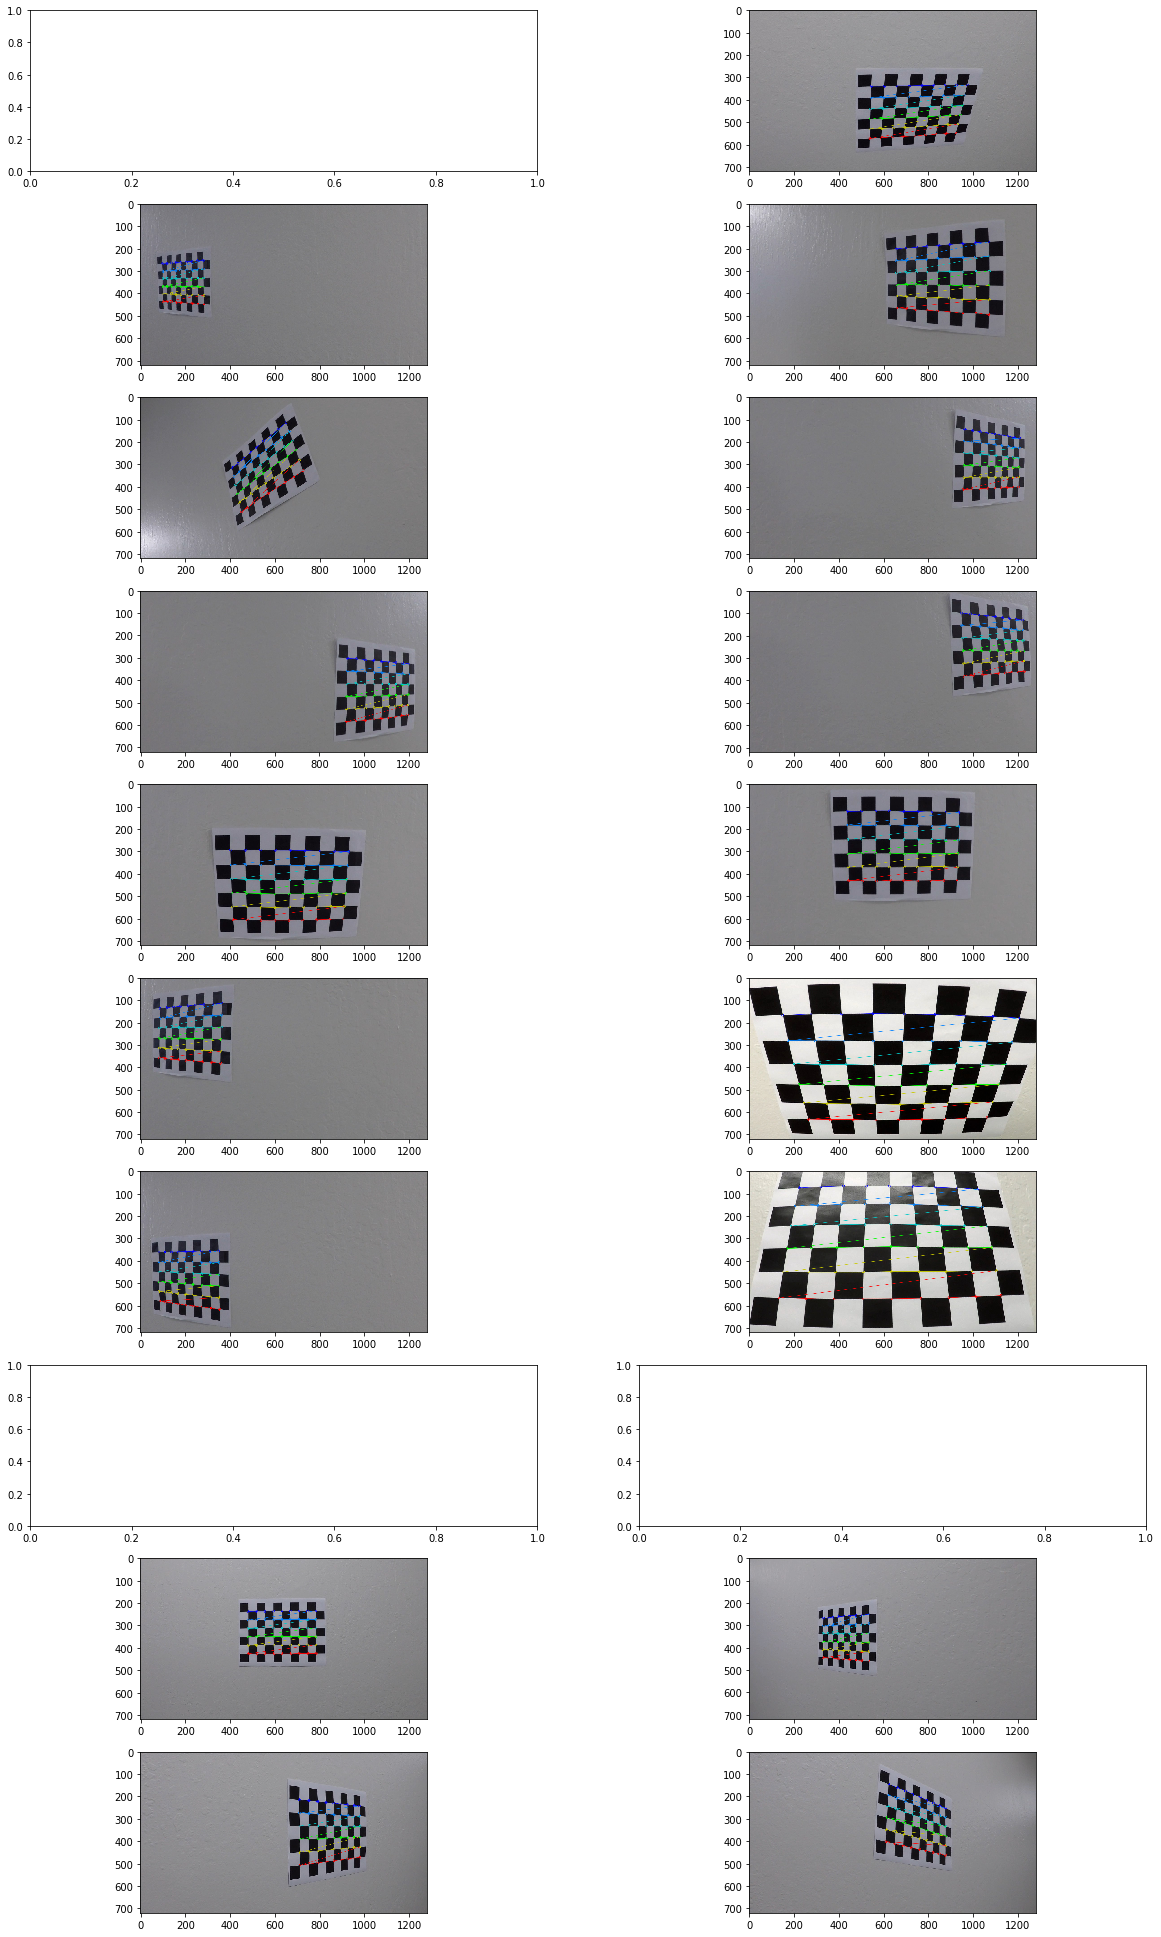

In [2]:
# Finding Corners

# Prepare object points
nx = 9
ny = 6

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Arrays to store object points and image points from the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prep object points
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # x,y coordinates

fig, ax = plt.subplots(10,2, figsize = (20, 35))
ax = ax.ravel()

# Step through each image in the calibration set
for n, fname in enumerate(images):
    # read in each image
    img = mpimg.imread(fname)
    # convert to grayscaele
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        ax[n].imshow(img)
        #cv2.imwrite("output_images/corners_" + fname, img)

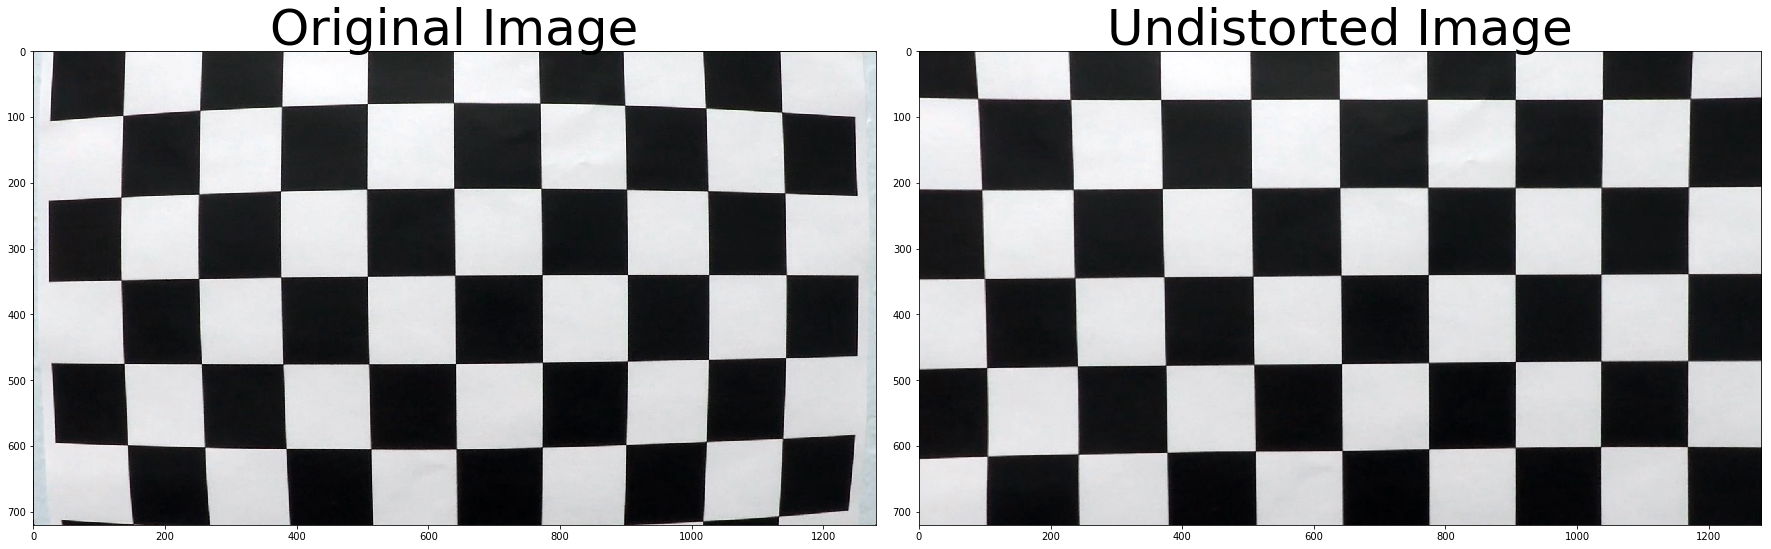

In [3]:
# Use the results obtained above to undistort an image
img = cv2.imread('./camera_cal/calibration1.jpg')

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
undistort = cv2.undistort(img, mtx, dist, None, mtx)



'''
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

undistorted = cal_undistort(img, objpoints, imgpoints)
'''
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistort)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#cv2.imwrite("output_images/undistorted_" + fname, undistorted)
plt.imsave('./output_images/undistorted.jpg',undistort)

In [4]:
# Save the camera calibration result (we don't need rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_dist_data.p", "wb" ) )

In [5]:
# load pickled distortion matrix
with open('camera_dist_data.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

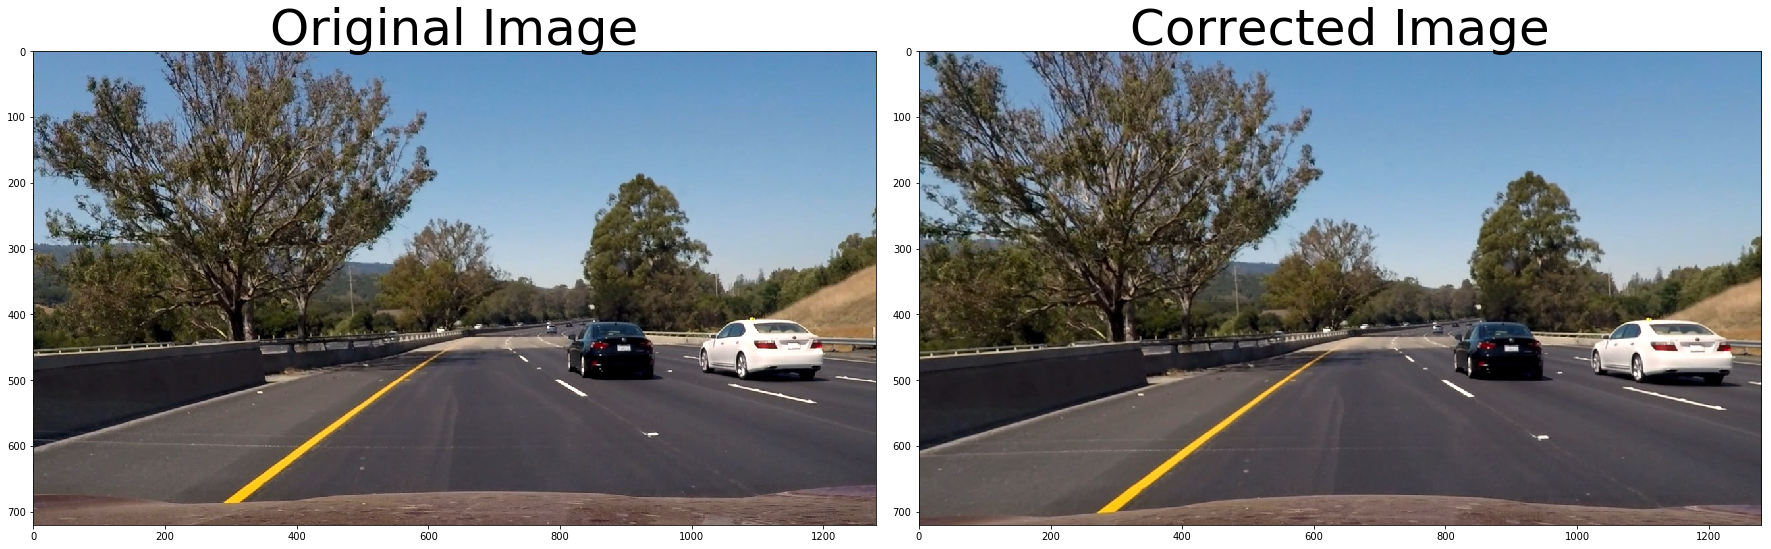

In [6]:
# Image to use as an example
example = cv2.imread('./test_images/test6.jpg')
example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)

# Function to correct distortion of images
def distortionCorrection(img):
    corrected = cv2.undistort(img, mtx, dist, None, mtx)
    return corrected

example_corrected = distortionCorrection(example)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(example)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(example_corrected)
ax2.set_title('Corrected Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.imsave('./output_images/proj_corrected.jpg',example_corrected)

## Image Perspective Transform

In [7]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

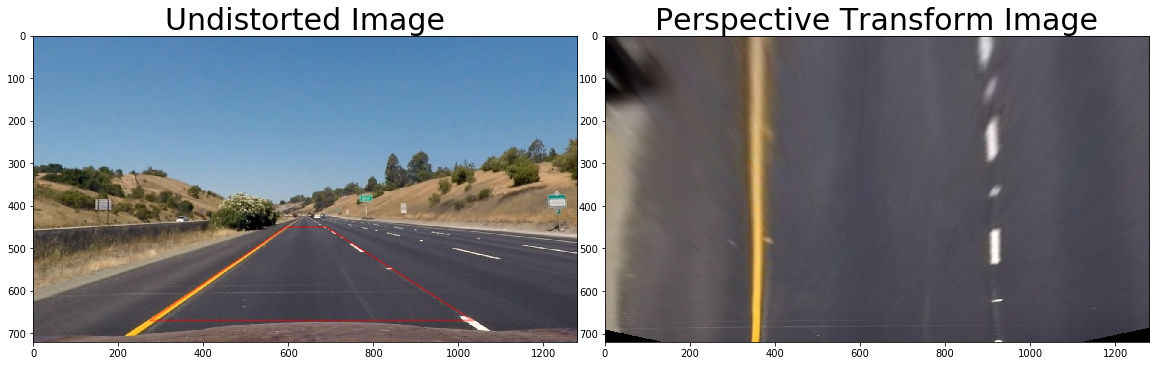

In [8]:
# Chose an image to use as an example for perspective transform
example_straight = cv2.imread('./test_images/straight_lines1.jpg')
example_straight = cv2.cvtColor(example_straight, cv2.COLOR_BGR2RGB)
example_straight_corrected = distortionCorrection(example_straight)

ex_image = example_straight_corrected

h,w = ex_image.shape[:2]

# define source and destination points for transform
src = np.float32([(595,450),
                  (690,450), 
                  (275,670), 
                  (1034,670)])
dst = np.float32([(350,0),
                  (w-350,0),
                  (350,h),
                  (w-350,h)])


ex_image_psptfm, M, Minv = unwarp(ex_image, src, dst)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(ex_image)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color= (1, 0, 0), alpha=0.4, linewidth=2, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(ex_image_psptfm)
ax2.set_title('Perspective Transform Image', fontsize=30)


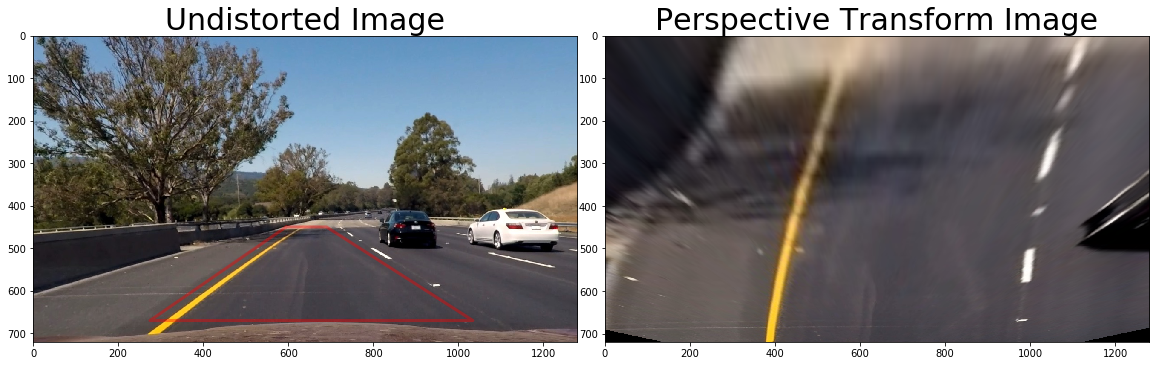

In [9]:
example_corrected_psptfm, M, Minv = unwarp(example_corrected, src, dst)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(example_corrected)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color= (1, 0, 0), alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(example_corrected_psptfm)
ax2.set_title('Perspective Transform Image', fontsize=30)
plt.imsave('./output_images/warp.jpg',example_corrected_psptfm)

In [10]:
def apply_thresh(img, thresh = (0, 255)):
    binary_out = np.zeros_like(img)
    binary_out[(img >= thresh[0])&(img <= thresh[1])] = 1
    return binary_out

def color_chan_and_thresh(img, thresh = (0, 255), color_chan = 0, color_space = None, 
                          sobel_kernel = 3, sobel_type = None, trans = 'n'):
    if color_space == 'HSV':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'HLS':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    elif color_space == 'Luv':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)
    elif color_space == 'Lab':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    elif color_space == 'YUV':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'gray':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if color_space != 'gray':
        img = img[:,:,(color_chan - 1)]
        
    if sobel_type != None:
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    if sobel_type == 'SX':
        img = np.absolute(sobelx)
        img = np.uint8(255*img/np.max(img))
    elif sobel_type == 'SY':
        img = np.absolute(sobely)
        img = np.uint8(255*img/np.max(img))
    elif sobel_type == 'SM':
        img = np.sqrt(sobelx**2 + sobely**2)
        img = np.uint8(255*img/np.max(img))
    elif sobel_type == 'SD':
        sobelx = np.abs(sobelx)
        sobely = np.abs(sobely)
        img = np.arctan2(sobely, sobelx)
    
    if trans == 'y':
        return img, apply_thresh(img, thresh)
    return apply_thresh(img, thresh)
        

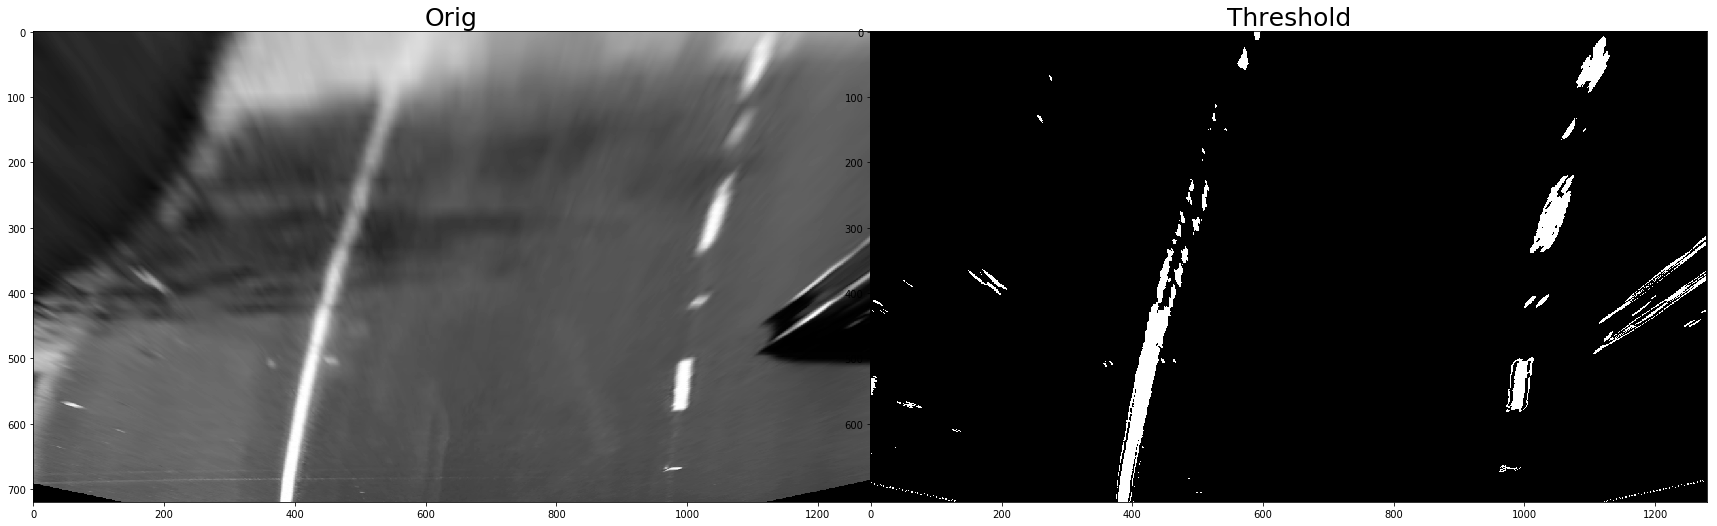

In [11]:
ex2 = cv2.imread('./test_images/test6.jpg')
ex2 = cv2.cvtColor(ex2, cv2.COLOR_BGR2RGB)
ex2_c = distortionCorrection(ex2)
ex2_tfm, _, _ = unwarp(ex2_c, src, dst)

#test, thresh = color_chan_and_thresh(ex2_tfm, (220,255), 3, 'HSV', trans = 'y')    # Changed Very Good
#test, thresh = color_chan_and_thresh(ex2_tfm, (30,100), 2, 'HLS', 3, 'SX', trans = 'y')
#test, thresh = color_chan_and_thresh(ex2_tfm, (30,100), 2, 'HLS', 3, 'SM', trans = 'y')    # Double Line
#test, thresh = color_chan_and_thresh(ex2_tfm, (200,255), 2, 'HLS', 3, None, trans = 'y')    # R-Good L-None
#test, thresh = color_chan_and_thresh(ex2_tfm, (150,255), 3, 'HLS', 3, None, trans = 'y')    # GOOD
#test, thresh = color_chan_and_thresh(ex2_tfm, (150,255), 0, 'gray', 3, None, trans = 'y')
#test, thresh = color_chan_and_thresh(ex2_tfm, (200,255), 3, 'RGB', 3, None, trans = 'y')    # R-Good
#test, thresh = color_chan_and_thresh(ex2_tfm, (50,120), 3, 'RGB', 3, None, trans = 'y')    # L-ok,messy - Added
#test, thresh = color_chan_and_thresh(ex2_tfm, (200,255), 1, 'RGB', 3, None, trans = 'y')    # Changed

orig1, thresh1 = color_chan_and_thresh(ex2_tfm, (220,255), 3, 'HSV', trans = 'y')    # Changed Very Good
orig2, thresh2 = color_chan_and_thresh(ex2_tfm, (35,100), 2, 'gray', 3, 'SX', trans = 'y')    # Good but with extras

combined = np.zeros_like(thresh1)
combined[((thresh1 == 1) | (thresh2 == 1))] = 1

test = combined

fig, ax = plt.subplots(1,2, figsize = (30,20))
ax = ax.ravel()
fig.subplots_adjust(hspace = .2, wspace=.001)
ax[0].imshow(orig1, cmap = 'gray')
ax[0].set_title('Orig', fontsize=25)
ax[1].imshow(combined, cmap = 'gray')
ax[1].set_title('Threshold', fontsize=25)
plt.imsave('./output_images/combined.jpg',combined)

In [12]:
def pipeline(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = distortionCorrection(img)
    img, M, Minv = unwarp(img, src, dst)
    
    orig1, thresh1 = color_chan_and_thresh(img, (220,255), 3, 'HSV', trans = 'y')    # Changed Very Good
    orig2, thresh2 = color_chan_and_thresh(img, (35,100), 2, 'gray', 3, 'SX', trans = 'y')    # Good but with extras

    combined = np.zeros_like(thresh1)
    combined[((thresh1 == 1) | (thresh2 == 1))] = 1
    
    return combined, Minv
    

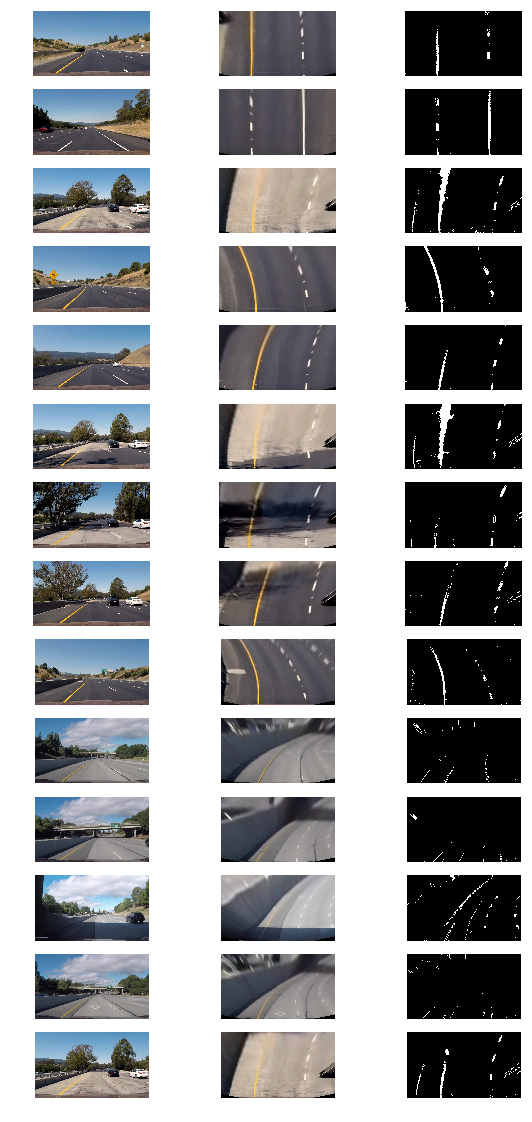

In [13]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),3, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    imge = cv2.imread(image)
    imge_t = cv2.cvtColor(imge, cv2.COLOR_BGR2RGB)
    img_persp_trans, M, Minv = unwarp(imge_t, src, dst)
    img_bin, Minv = pipeline(imge)
    axs[i].imshow(imge_t)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_persp_trans, cmap='gray')
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

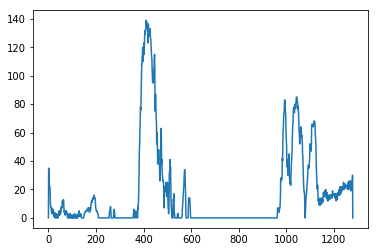

In [14]:
orig = cv2.imread('./test_images/test6.jpg')
hist_ex, Minv = pipeline(orig)
# Using entire image for the histogram, some images did not have lines below the mid point.
#histogram = np.sum(hist_ex[hist_ex.shape[0]//2:,:], axis = 0)
histogram = np.sum(hist_ex, axis = 0)

plt.plot(histogram)

In [15]:
#binary_warped = hist_ex
def sliding_window_fit(binary_warped, vis_data = 'n'):
    # Take a histogram of the image
    histogram = np.sum(binary_warped, axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    # Moved in the search for the base position because some artifacts near 
    leftx_base = np.argmax(histogram[200:midpoint])+200
    rightx_base = np.argmax(histogram[midpoint:histogram.shape[0] - 200]) + midpoint


    # Choose the number of sliding windows
    nwindows = 5
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 70
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if vis_data != 'n':
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img


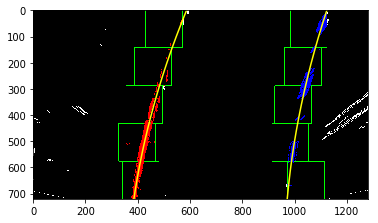

In [16]:
# Generate x and y values for plotting
left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img = sliding_window_fit(hist_ex, 'y')
ploty = np.linspace(0, hist_ex.shape[0]-1, hist_ex.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.imsave('./output_images/fit_lines.jpg',out_img)

In [17]:
def fit_from_prev(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 60
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy


May need to modify margin here - Test first

(720, 0)

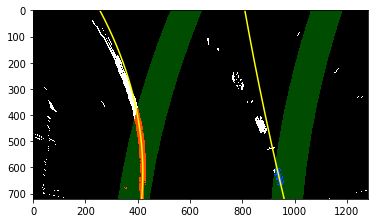

In [18]:
hist_ex2 = cv2.imread('./test_images/test7.jpg')
hist_ex2, _ = pipeline(hist_ex2)

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2, nonzerox2, nonzeroy2 = fit_from_prev(hist_ex2, left_fit, right_fit)
margin = 60
# Generate x and y values for plotting
ploty2 = np.linspace(0, hist_ex2.shape[0]-1, hist_ex2.shape[0] )
left_fitx2 = left_fit2[0]*ploty2**2 + left_fit2[1]*ploty2 + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty2**2 + right_fit2[1]*ploty2 + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img2 = np.dstack((hist_ex2, hist_ex2, hist_ex2))*255
window_img = np.zeros_like(out_img2)
# Color in left and right line pixels
out_img2[nonzeroy2[left_lane_inds2], nonzerox2[left_lane_inds2]] = [255, 0, 0]
out_img2[nonzeroy2[right_lane_inds2], nonzerox2[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img2, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty2, color='yellow')
plt.plot(right_fitx2, ploty2, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [19]:
def calc_curv_and_center(img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/95 # meters per pixel in y dimension
    xm_per_pix = 3.7/600 # meters per pixel in x dimension

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Car distance from center
    h = img.shape[0]
    car_position = img.shape[1]/2
    l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center_dist = (car_position - lane_center_position) * xm_per_pix
    
    return left_curverad, right_curverad, center_dist

In [20]:
left_curverad, right_curverad, center = calc_curv_and_center(hist_ex, left_fit, right_fit, left_lane_inds, right_lane_inds)
print(left_curverad, right_curverad, center)

441.377461512 485.395575071 -0.238223561408


In [21]:
def draw_lane(img_orig, img_bin, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, Minv):
    nonzero = img_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_bin).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp2 = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, img_bin.shape[0]-1, num=img_bin.shape[0])# to cover same y-range as image
    if left_fit is not None:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    if right_fit is not None:
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    color_warp2[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    color_warp2[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_orig.shape[1], img_orig.shape[0]))
    newwarp2 = cv2.warpPerspective(color_warp2, Minv, (img_orig.shape[1], img_orig.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_orig, 1, newwarp, 0.3, 0)
    result = cv2.addWeighted(result, 0.9, newwarp2, 0.9, 0)

    return result

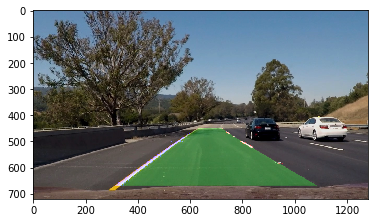

In [22]:
final_img = draw_lane(orig, hist_ex, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, Minv)
final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
plt.imshow(final_img)
#plt.imsave('./output_images/'+'final_image.jpg',final_img)    # Code to save images

In [23]:
def add_data_to_image(image, curve_rad, offset):
    img_copy = np.copy(image)
    font = cv2.FONT_HERSHEY_SIMPLEX
    data = "Curve: " + '{:04.2f}'.format(curve_rad) + 'm'
    cv2.putText(img_copy, data, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    data = "Center: " + '{:04.3f}'.format(offset) + 'm'
    cv2.putText(img_copy, data, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return img_copy
    

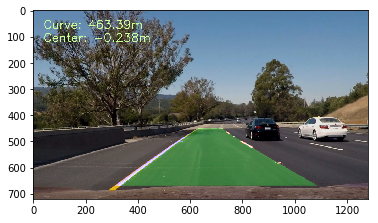

In [24]:
exampleImg_out2 = add_data_to_image(final_img, (left_curverad+right_curverad)/2, center)
plt.imshow(exampleImg_out2)
plt.imsave('./output_images/output.jpg',exampleImg_out2)

In [25]:

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # number of elements to store
        self.n = 5
        # Current number of buffered elements
        self.n_current = 0
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_fits = [np.array(False)] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        self.prev_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    def add_fit(self, fit, inds):
        if fit is not None:
            self.prev_fit = self.current_fit
            self.current_fit = fit
            self.detected = True
        else:
            self.detected = False
        
        
            
       
        

In [26]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    
    if l_line.detected is True and r_line.detected is True:
        l_fit, r_fit, l_lane_inds, r_lane_inds, nonzerox, nonzeroy = fit_from_prev(img_bin, l_line.current_fit, r_line.current_fit)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds, nonzerox, nonzeroy, _ = sliding_window_fit(img_bin)
    
    
    
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
    
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)

    if l_fit is not None and r_fit is not None:
        #img_out = draw_lane(new_img, img_bin, l_fit, r_fit, l_lane_inds, r_lane_inds, nonzerox, nonzeroy, Minv)
        img_out = draw_lane(new_img, img_bin, l_line.current_fit, r_line.current_fit, l_lane_inds, r_lane_inds, nonzerox, nonzeroy, Minv)
        #img_out = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, l_lane_inds, r_lane_inds, nonzerox, nonzeroy, Minv)
        #plt.imshow(img_out1)
        #calc_curv_and_center(img, left_fit, right_fit, left_lane_inds, right_lane_inds)
        rad_l, rad_r, d_center = calc_curv_and_center(img_bin, l_fit, r_fit, l_lane_inds, r_lane_inds)
        #img_out = draw_lane(img_out1, img_bin, l_line.current_fit, r_line.current_fit, l_lane_inds, r_lane_inds, nonzerox, nonzeroy, Minv)
        img_out = add_data_to_image(img_out, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img

    return img_out

In [27]:
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img

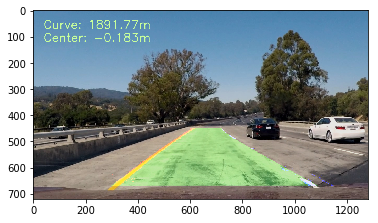

In [28]:
l_line = Line()
r_line = Line()
image_test = cv2.imread('./test_images/test1.jpg')
final_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
final_test = process_image(final_test)
plt.imshow(final_test)

In [29]:
from moviepy.editor import VideoFileClip

l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:57<00:00,  7.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 5s, sys: 52.5 s, total: 4min 58s
Wall time: 2min 57s
